In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pathlib
%matplotlib inline

torch.manual_seed(0)
np.random.seed(0)

device = 'cuda:1'
noise = 0.25
exp_name = 'noise_025_heat_eq_pinn'
pathlib.Path(f"./{exp_name}/").mkdir(parents=True, exist_ok=True)

In [2]:
class PINN(nn.Module):
    def __init__(self, X_0, u_0, X_b, u_b, X_r, num_hidden_layers=2, hidden_layer_size=25, alpha=0.2, device=device):
        super().__init__()
        self.device = device

        self.t_0cpu = X_0[:, 0].reshape(-1, 1).clone().detach().cpu()
        self.x_0cpu = X_0[:, 1].reshape(-1, 1).clone().detach().cpu()
        self.u_0cpu = u_0.clone().detach().cpu()

        self.t_0 = X_0[:, 0].reshape(-1, 1).clone().detach().requires_grad_(True).to(device)
        self.x_0 = X_0[:, 1].reshape(-1, 1).clone().detach().requires_grad_(True).to(device)
        self.u_0 = u_0.to(device)

        self.t_b = X_b[:, 0].reshape(-1, 1).clone().detach().requires_grad_(True).to(device)
        self.x_b = X_b[:, 1].reshape(-1, 1).clone().detach().requires_grad_(True).to(device)
        self.u_b = u_b.to(device)

        self.t_r = X_r[:, 0].reshape(-1, 1).clone().detach().requires_grad_(True).to(device)
        self.x_r = X_r[:, 1].reshape(-1, 1).clone().detach().requires_grad_(True).to(device)

        self.all_t = torch.cat([self.t_0, self.t_b, self.t_r], dim=0)
        self.all_x = torch.cat([self.x_0, self.x_b, self.x_r], dim=0)

        layers = nn.ModuleList()
        layers.append(nn.Sequential(nn.Linear(2, hidden_layer_size), nn.Tanh()))
        for i in range(num_hidden_layers):
            layers.append(nn.Sequential(nn.Linear(hidden_layer_size, hidden_layer_size), nn.Tanh()))
        layers.append(nn.Sequential(nn.Linear(hidden_layer_size, 1)))
        self.u_theta = nn.Sequential(*layers)

        self.mse = nn.MSELoss()
        self.alpha = alpha

        self.to(device)
        
    def forward(self, t, x):
        return self.u_theta(torch.cat([t, x], dim=1))
    
    def residual(self, t, x):
        u = self.forward(t, x)

        u_t = torch.autograd.grad(u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_x = torch.autograd.grad(u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]
        
        u_xx = torch.autograd.grad(u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]
        
        return u_t - self.alpha * u_xx
    
    def u_star(self, t, x):
        return torch.exp(-self.alpha * torch.pi * torch.pi * t) * torch.sin(torch.pi * x)
    
    def loss(self):
        u_0_pred = self.forward(self.t_0, self.x_0)
        u_b_pred = self.forward(self.t_b, self.x_b)

        residual = self.residual(self.t_r, self.x_r)

        loss_0b = self.mse(torch.vstack((u_0_pred, u_b_pred)), torch.vstack((self.u_0, self.u_b)))
        loss_r = self.mse(residual, torch.zeros_like(residual))

        true_mse = self.mse(self.u_star(self.all_t, self.all_x), self.forward(self.all_t, self.all_x))

        return loss_0b + loss_r, true_mse

    def train(self, epochs=1000, schedule_step_size=7500, plot=False, sigma=None):
        optimizer = torch.optim.SGD(self.u_theta.parameters(), lr=1e-1)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=schedule_step_size, gamma=0.1)

        losses = []
        mse_loss = []
        figs = []

        def train_step():
            self.u_theta.train()

            optimizer.zero_grad()
            loss, total_mse = self.loss()
            loss.backward()
            optimizer.step()
            return loss.item(), total_mse.item()

        for epoch in tqdm(range(epochs)):
            loss, total_mse = train_step()
            losses.append(loss)
            mse_loss.append(total_mse)
            scheduler.step()

            if plot and epoch % 100 == 0:
                self.plot_solution(sigma=sigma, epoch=epoch)
                plt.savefig(f"./{exp_name}/{epoch}.png", bbox_inches='tight')
                plt.close()
                figs.append(f"./{exp_name}/{epoch}.png")

        self.u_theta.eval()

        return losses, mse_loss, figs
    
    def lbfgs(self):
        optimizer = torch.optim.LBFGS(self.u_theta.parameters(), 
                                      lr=0.01, 
                                      max_iter=10000, 
                                      max_eval=10000, 
                                      history_size=500, 
                                      tolerance_grad=1e-5, 
                                      tolerance_change=0.5 * np.finfo(float).eps, 
                                      line_search_fn="strong_wolfe")
        
        self.u_theta.train()

        iter = 0
        losses = []
        mse_loss = []

        def closure():
            nonlocal iter, losses, mse_loss
            optimizer.zero_grad()
            loss, total_mse = self.loss()
            loss.backward()

            iter += 1
            losses.append(loss.item())
            mse_loss.append(total_mse.item())

            if iter % 100 == 0:
                print(f"Iteration {iter}: Loss {loss}")

            return loss

        optimizer.step(closure)

        self.u_theta.eval()
        return losses, mse_loss

    def plot_solution(self, sigma=None, epoch=None, error=None):
        # Set up meshgrid
        N = 600
        tspace = np.linspace(0, 1, N + 1)
        xspace = np.linspace(0, 1, N + 1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T

        # Determine predictions of u(t, x)
        upred = self.u_theta(torch.from_numpy(Xgrid).float().to(self.device))

        # Reshape upred
        U = upred.detach().cpu().numpy().reshape(N+1,N+1)

        # Surface plot of solution u(t,x)
        fig = plt.figure(figsize=(16,24))
        ax1 = fig.add_subplot(1, 1, 1, projection='3d')
        ax1.plot_surface(T, X, U, cmap='viridis')
        ax1.view_init(35,35)

        eps = 0.025
        ax1.axes.set_xlim3d(left=0.-eps, right=1+eps)
        ax1.axes.set_ylim3d(bottom=0.-eps, top=1+eps) 
        ax1.axes.set_zlim3d(bottom=0.-eps, top=1.2+eps) 

        ax1.scatter(self.t_0cpu, self.x_0cpu, self.u_0cpu, facecolors='none', edgecolors='r', s=100)
        ax1.plot(np.zeros_like(xspace), xspace, np.sin(np.pi*xspace), linestyle='--', linewidth=4, color='r')

        ax1.set_xlabel('$t$')
        ax1.set_ylabel('$x$')
        ax1.set_zlabel('$u_\\theta(t,x)$')
        if sigma is not None:
            if epoch is not None:
                ax1.set_title(f'PINN Approximation ($\sigma = {sigma:.2f}$)\nEpoch: {epoch}')
            elif error is not None:
                ax1.set_title(f'PINN Approximation ($\sigma = {sigma:.2f}$)\nFinal MSE: {error:.6e}')
        else:    
            ax1.set_title('PINN Approximation')
    
    def plot_loss(self, losses):
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111)
        ax.semilogy(range(len(losses)), losses,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi_{n_{epoch}}$')

        fig.show()

In [3]:
def generate_data(sigma=0):
    N1 = 50     # Number of points with final condition, i.e. t = 1
    Nb = 50     # Number of points with boundary condition, i.e. x = -1 or x = 1
    Nr = 10000  # Number of collocation points, i.e. (t,x) in (0, 1) x [-1,1]

    # Initial conditions, t = 0
    t_0 = torch.zeros((N1, 1), dtype=torch.float32)
    x_0 = torch.linspace(0, 1, N1).reshape(-1, 1)
    X_0 = torch.cat((t_0, x_0), dim=1)
    u_0 = torch.sin(torch.pi * x_0) # Evaluation of the initial condition
    u_0 += sigma * torch.randn_like(u_0)

    # Boundary conditions, x = 0 or x = 1
    t_b = torch.linspace(0, 1, Nb).repeat(1,2).reshape(-1, 1)
    x_b = torch.vstack((torch.zeros((Nb, 1), dtype=torch.float32), torch.ones((Nb, 1), dtype=torch.float32)))
    X_b = torch.cat((t_b, x_b), dim=1)
    u_b = torch.zeros((2 * Nb, 1), dtype=torch.float32) # Evaluation of the boundary condition

    # Collocation points
    t_r = torch.rand((Nr, 1), dtype=torch.float32)
    x_r = torch.rand((Nr, 1), dtype=torch.float32)
    X_r = torch.cat((t_r, x_r), dim=1)

    return X_0, u_0, X_b, u_b, X_r

In [4]:
X_0, u_0, X_b, u_b, X_r = generate_data(sigma=noise)
fig = plt.figure(figsize=(9,6))
plt.scatter(X_0[:, 0], X_0[:, 1], c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(X_b[:, 0], X_b[:, 1], c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(X_r[:, 0], X_r[:, 1], c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
plt.savefig(f"./{exp_name}/data.png")
plt.close()

100%|██████████| 10000/10000 [15:22<00:00, 10.84it/s] 


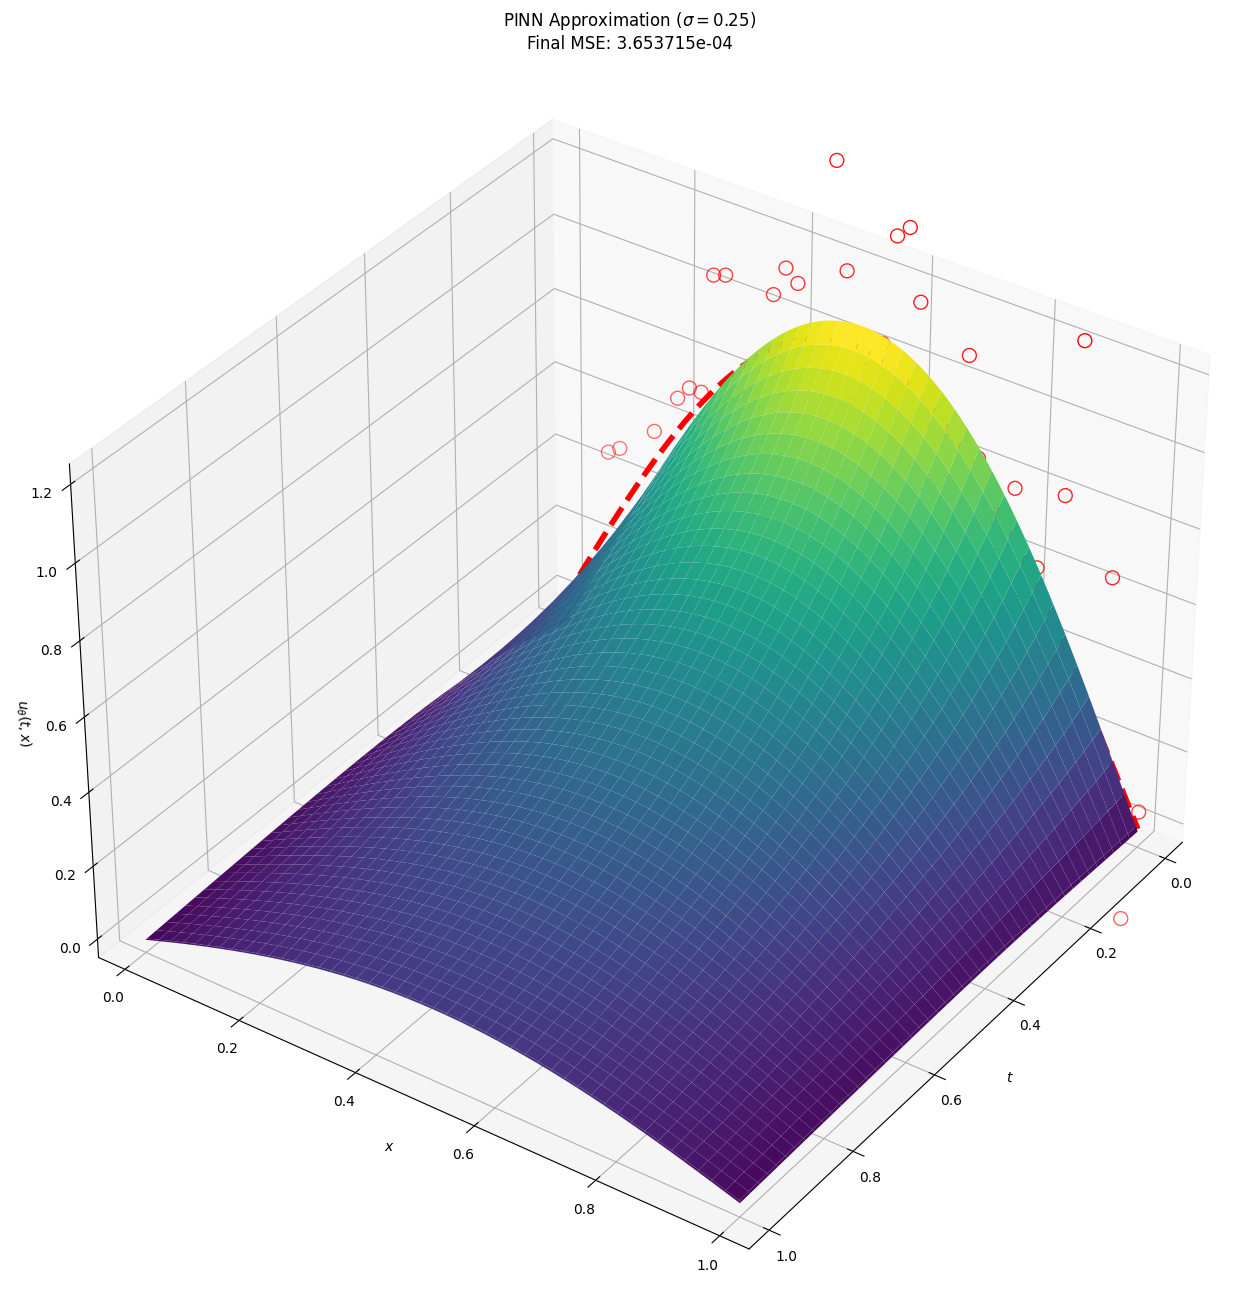

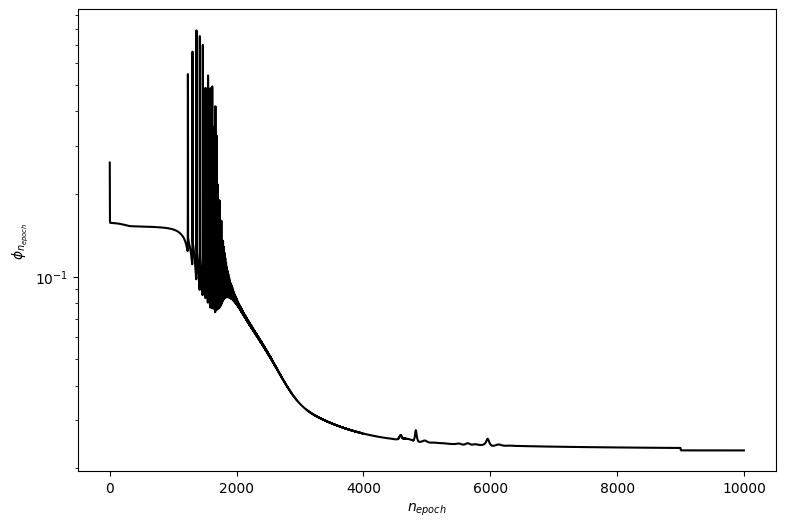

In [5]:
model0 = PINN(X_0, u_0, X_b, u_b, X_r, num_hidden_layers=8, device="cuda:1")
losses0, total_mses0, figs0 = model0.train(epochs=10000, schedule_step_size=9000, plot=True, sigma=noise)

model0.plot_solution(sigma=noise, error=total_mses0[-1])
plt.savefig(f"./{exp_name}/final.png", bbox_inches='tight')

model0.plot_loss(losses0)
plt.savefig(f"./{exp_name}/loss.png", bbox_inches='tight')

In [6]:
import imageio
with imageio.get_writer(f"./{exp_name}/d3_progression.gif", mode="I", duration=0.01, loop=True) as w:
    for fname in tqdm(figs0):
        w.append_data(imageio.imread(fname))

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2808014/2974621507.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  w.append_data(imageio.imread(fname))


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]
